In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datetime

# データフレームの項目
COLUMNS = ['抽選会', '抽選日付', '本数字1', '本数字2', '本数字3', '本数字4', '本数字5', 'B数字', 'セット']

# 抽選回(文字列)から抽選日を抽出する
# @param draw_number 抽選会(文字列)
# @return draw_date 抽選日(datetime)
def get_draw_date(draw_number):
    number = draw_number[1:-1]
    detail_url = f"http://sougaku.com/miniloto/data/detail/index{number}.html"
    # print(detail_url)
    response = requests.get(detail_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    for row in soup.find_all('tr'):
        cols = row.find_all('td')
        if cols: # 空の行を無視
            if '年' in str(cols):
                raw = cols[1].text.strip().split('(')[0]
                tdatetime = datetime.datetime.strptime(cols[1].text.strip().split('(')[0], '%Y年%m月%d日')
                tdate = datetime.date(tdatetime.year, tdatetime.month, tdatetime.day)
                print(raw, tdate)
                return tdate

# 過去の当選番号データを抽出する
# @param url 過去の当選番号を掲載しているサイトURL
# @return df 過去の当選番号一覧データフレーム
def fetch_miniloto_results(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # 結果を格納するリスト
    results = []

    # 各行をループしてデータを抽出
    for row in soup.find_all('tr')[8:]:  # 余分な行と第0回を除く
        cols = row.find_all('td')
        if cols:  # 空の行を無視
            if '％' in str(cols):
                continue
            draw_number = str(cols[0].text.strip())  # 抽選回
            draw_date = get_draw_date(draw_number)
            main_number1 = int(cols[1].text.strip())  # 本数字1
            main_number2 = int(cols[2].text.strip())  # 本数字2
            main_number3 = int(cols[3].text.strip())  # 本数字3
            main_number4 = int(cols[4].text.strip())  # 本数字4
            main_number5 = int(cols[5].text.strip())  # 本数字5
            bonus_number = int(cols[6].text.strip())  # B数字
            set_number = str(cols[7].text.strip())  # セット
            results.append([draw_number, draw_date, main_number1, main_number2, main_number3, main_number4, main_number5, bonus_number, set_number])

    # 結果をpandas DataFrameに変換
    df = pd.DataFrame(results, columns=COLUMNS)
    return df

# URLの指定
url = "http://sougaku.com/miniloto/data/list1/"

# 結果の抽出
# miniloto_df = fetch_miniloto_results(url)

# 結果の出力
# miniloto_df.to_csv('./result.csv')
miniloto_df = pd.read_csv('./result.csv')

# 結果の表示
print(miniloto_df)

c:\Users\atsud\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


      Unnamed: 0     抽選会        抽選日付  本数字1  本数字2  本数字3  本数字4  本数字5  B数字 セット
0              0     第1回  1999-04-13     1     3    17    20    25   26   A
1              1     第2回  1999-04-27     2    11    12    21    30   28   B
2              2     第3回  1999-05-11     1     8    10    24    30   28   E
3              3     第4回  1999-05-25    11    12    14    20    31   29   C
4              4     第5回  1999-06-08     8     9    15    21    25   23   D
...          ...     ...         ...   ...   ...   ...   ...   ...  ...  ..
1275        1275  第1276回  2024-03-26     4     9    13    16    31   27   H
1276        1276  第1277回  2024-04-02     2    13    18    22    28   30   B
1277        1277  第1278回  2024-04-09     3    10    19    21    31   29   J
1278        1278  第1279回  2024-04-16     1    14    18    22    28   26   D
1279        1279  第1280回  2024-04-23     7     9    14    17    20   13   A

[1280 rows x 10 columns]


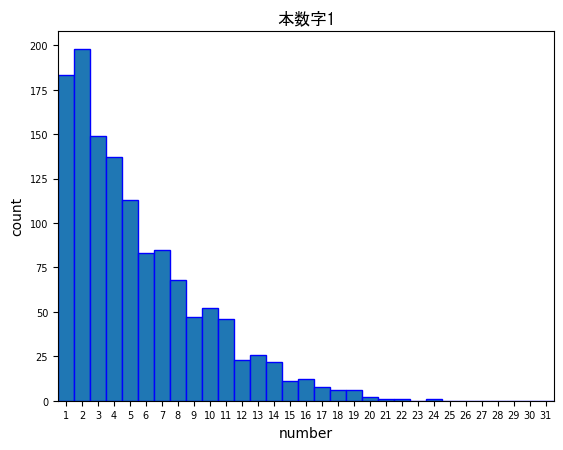

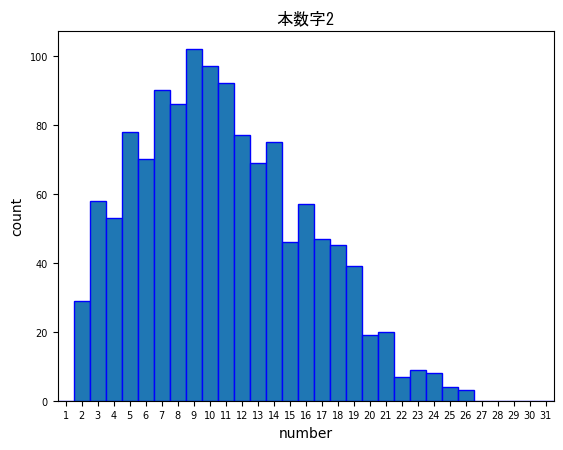

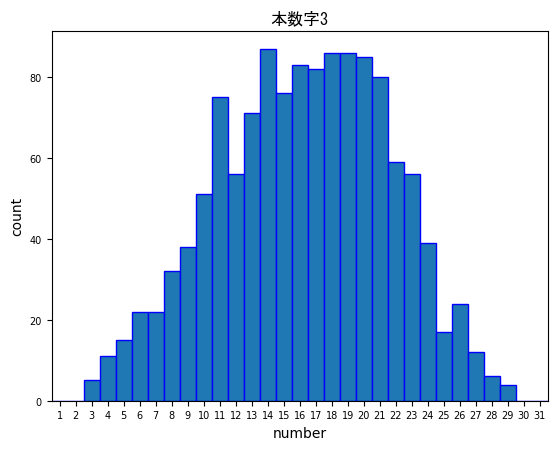

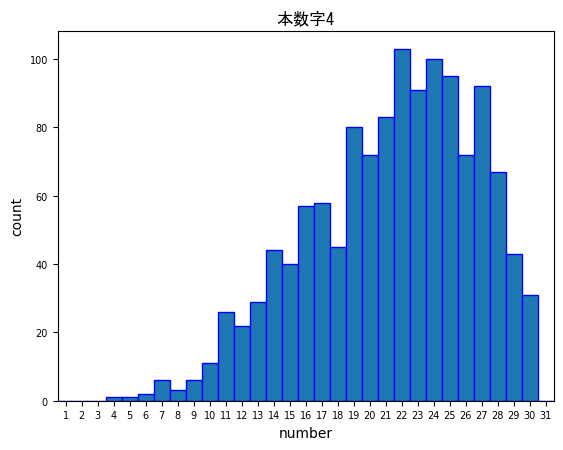

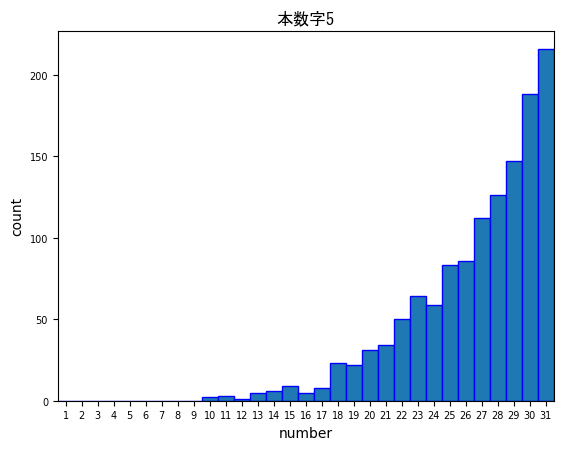

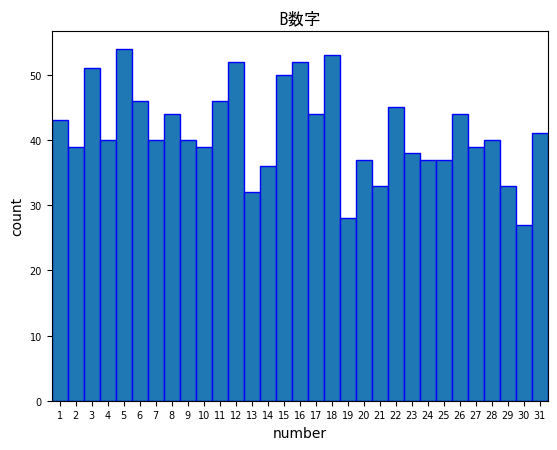

In [9]:
# グラフ出力
import matplotlib.pyplot as plt
import numpy as np

def plot_count_hist_by_key(df, key):
    plt.hist(df[key].values-0.5, bins=np.arange(0.5, 32.5, 1.0), edgecolor='b')
    plt.tick_params(labelsize=7)
    plt.xlim([0.5, 31.5])
    plt.xticks(range(1, 32))
    plt.xlabel('number')
    plt.ylabel('count')
    plt.title(key, fontname='MS Gothic')
    plt.show()

for key in COLUMNS[2:-1]:
    plot_count_hist_by_key(miniloto_df, key)

In [24]:
from prophet import Prophet

def predict_minnumber(df):
    # データ準備
    dataset = miniloto_df[['抽選日付', '本数字1']].rename(columns={'抽選日付': 'ds', '本数字1': 'y'})
    # print(type(dataset))

    # モデル
    model = Prophet()

    # 学習
    model.fit(dataset)

    # 推論
    feature = model.make_future_dataframe(periods=7)
    feature.tail()
    result = model.predict(feature)
    r = result[-1:]
    return r['yhat']

In [17]:
import numpy as np
from collections import Counter
from ortools.linear_solver import pywraplp

# 出現確率の計算
def calculate_probabilities(past_draws):
    counter = Counter(np.hstack(past_draws))
    total_draws = len(past_draws)
    probabilities = {number: count / total_draws for number, count in counter.items()}
    return probabilities

# 出現確率が高い5個の数字を予測
def predict_numbers(past_draws, num_predictions=5):
    # 各数字の出現確率を計算
    probabilities = calculate_probabilities(past_draws)

    # OR-toolsを使って最適な5つの数字を選択
    solver = pywraplp.Solver.CreateSolver('SCIP')
    
    # 変数の定義 (1 = 数字を選択, 0 = 選択しない)
    vars = {i: solver.BoolVar(f'x_{i}') for i in range(1, 32)}
    
    # 制約：ちょうど5つの数字を選ぶ
    solver.Add(solver.Sum([vars[i] for i in range(1, 32)]) == num_predictions)
    
    # 目的関数：確率の高い数字を選択
    objective = solver.Sum([vars[i] * probabilities.get(i, 0) for i in range(1, 32)])
    solver.Maximize(objective)
    
    # ソルバーを実行
    status = solver.Solve()
    
    if status == pywraplp.Solver.OPTIMAL:
        print('Solution:')
        result = [i for i in range(1, 32) if vars[i].solution_value() > 0.5]
        print(result)
        return result
    else:
        print('No solution found')
        return []

# 過去当選番号と予測最小値から残りの4つの数字を予測
def predict_remaining_numbers(past_draws, predicted_min):
    probabilities = calculate_probabilities(past_draws)
    
    # OR-toolsを使って最適な4つの数字を選択
    solver = pywraplp.Solver.CreateSolver('SCIP')
    vars = {i: solver.BoolVar(f'x_{i}') for i in range(predicted_min + 1, 32)}
    
    # 制約：ちょうど4つの数字を選ぶ
    solver.Add(solver.Sum(vars[i] for i in vars) == 4)
    
    # 目的関数：確率の高い数字を選択
    objective = solver.Sum(vars[i] * probabilities.get(i, 0) for i in vars)
    solver.Maximize(objective)
    
    # ソルバーを実行
    status = solver.Solve()
    
    if status == pywraplp.Solver.OPTIMAL:
        print('Optimal solution found:')
        result = [i for i in vars if vars[i].solution_value() > 0.5]
        print(result)
        return result
    else:
        print('No optimal solution found')
        return []

# 過去の当選番号の例
# past_draws = [
#     [1, 6, 14, 25, 27],
#     [4, 11, 16, 19, 31],
#     [2, 3, 15, 21, 30],
#     # 他の過去のデータ
# ]
past_draws = []
for index, row in miniloto_df[['本数字1', '本数字2', '本数字3', '本数字4', '本数字5']].iterrows():
    past_draws.append([row['本数字1'], row['本数字2'], row['本数字3'], row['本数字4'], row['本数字5']])

# 予測を実行
predict_numbers(past_draws)


Solution:
[2, 11, 14, 19, 22]


[2, 11, 14, 19, 22]